In [1]:
import numpy as np
from matplotlib import pyplot as plt
from molecular_generation_utils import *
from invert_CM import *
import torch
from Model import Multi_VAE
from torch.distributions.categorical import Categorical
from tqdm import tqdm
import copy

reproduce_paper = False

if reproduce_paper:
    paper_path = '_paper'
else:
    paper_path = ''


properties = torch.load('./data/properties_total.pt'.format(paper_path))
p_means = torch.load('./data/properties_means.pt'.format(paper_path))
p_stds = torch.load('./data/properties_stds.pt'.format(paper_path))
norm_props = (properties - p_means)/p_stds

properties_list =  ['eAT', 'eMBD', 'eXX', 'mPOL', 'eNN', 'eNE', 'eEE', 'eKIN', 'DIP', 'HLgap', 'HOMO_0', 'LUMO_0', 'HOMO_1', 'LUMO_1', 'HOMO_2', 'LUMO_2', 'dimension']
p_arr = np.array(properties_list)

PATH = "last.ckpt"
#'./models_saved/masked/epoch=2597-step=145487.ckpt'

modello = Multi_VAE.load_from_checkpoint(
    PATH,
    map_location=torch.device('cpu'),
    structures_dim = len(torch.load('./data/data_val/CMs.pt')[0,:]),
    properties_dim = len(torch.load('./data/data_val/properties.pt')[0,:]),
    latent_size = 21,
    extra_dim = 32 - len(torch.load('./data/data_val/properties.pt')[0,:]),
    initial_lr = 1e-3,
    properties_means = p_means,
    properties_stds = p_stds,
    beta = 4.,
    alpha = 1.,
    decay = .01
)

# if you want the non-masked model uncomment this

# if reproduce_paper == True:
#     PATH='./special/VAE_reduced_21'
#     modello.VAE.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
#     PATH='./special/prop_ecoder_reduced_21'
#     modello.property_encoder.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

modello.eval()
modello.freeze()

Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v2.2.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint last.ckpt`


Fit the dataset property distribution with 91 (optional number) Gaussians

In [2]:
gm, labels = props_fit_Gaussian_mix(
    norm_props, 
    min_components = 91,
    max_components = 92
    )

100%|██████████| 1/1 [01:06<00:00, 66.43s/it]


using 91 components


In [28]:
# recall that here the target value is the normalized one

generated = start_generation(
    modello,
    {
        'mPOL': 2.,
        'eMBD': 2.
    },
    p_arr,
    177,
    int(5e3),
    gm.means_,
    gm.covariances_,
    cm_diff = 5,
    deltaz = 6,
    check_new_comp = False,
    verbose = False
)

. sampling...


In [21]:
generated

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 53.2490,
         27.9465,  0.0000, 29.6464, 28.7070, 18.0329, 11.5656,  0.0000,  0.0000,
          0.0000, 53.4911,  0.0000, 15.0017, 17.4622, 32.0798, 17.4420,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, 36.8712, 23.6193, 13.7001,  9.5845,  0.0000,  0.0000,
          0.0000, 36.8700, 16.9338, 10.4884,  0.0000,  0.0000,  0.0000, 36.8835,
         22.2107,  0.0000,  0.0000,  0.0000, 36.8683,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, 

In [6]:
# load the coulomb matrices in the dataset
CMs = torch.load('./data/CMs_total.pt'.format(paper_path))

In [24]:
generated.shape

torch.Size([11, 78])

In [31]:
CM = generated[177]

from invert_CM import *
from CM_preparation import *

distance_mat, master_vec2 = recover_distance_mat(
    CM 
)


print("Master Vector:", master_vec2)

# Recover the Cartesian coordinates
cartesian = cartesian_recovery(distance_mat)
# truncate last two columns
cartesian = cartesian[:,0:3]
# remove imaginary part
cartesian = np.real(cartesian)
print("Cartesian coordinates:", cartesian)

# Create the recovered ASE Atoms object
rec_mol = Atoms(symbols=master_vec2, positions=cartesian)
print("Recovered mol:")
view(rec_mol)
# Get the RMSD between the original and recovered molecule

Master Vector: [7, 7, 7, 6, 6, 6, 6]
Cartesian coordinates: [[ 0.          0.          0.        ]
 [-2.97932195  0.01391998  0.8499687 ]
 [ 1.15493985 -2.09494965 -0.78506197]
 [ 0.30538698 -2.21777407  1.08486012]
 [-2.23209952 -0.94078425 -0.78063634]
 [-2.63188328 -0.15410293 -0.53286497]
 [-0.59227469 -1.06840166  0.06275601]]
Recovered mol:


<Popen: returncode: None args: ['/Users/jan/miniconda3/bin/python', '-m', 'a...>

In [15]:
#find the closest mmatrix in the dataset

where_closest = []
for cm in generated:
    where_closest.append(torch.argmin(torch.norm(CMs - cm.view(1,-1), dim = 1)))
    #print(torch.norm(CMs - cm.view(1,-1), dim = 1).min())

In [16]:
#some visualization and optimization

import rmsd
from ase.visualize import view
from ase.optimize import BFGS, FIRE
from ase import Atoms
from ase.io import write, read
from openbabel import openbabel as ob
from ase.constraints import FixAtoms

# here choose the calculator you prefer, or do not optimize by commenting out the opt steps in the code
#from spooks.spookynet import SpookyNetCalculator, spookynet
#calc=SpookyNetCalculator(load_from="./spooks/qm7x_known_unknown_0.pth", charge=0, magmom=0)

n = 0
pos, comp = get_cartesian(generated[n,:].tolist())
print(len(comp))
atom = Atoms(comp, pos)
write('./temp.xyz', atom)
obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("xyz", "mol2")
mol = ob.OBMol()
obConversion.ReadFile(mol, "temp.xyz")  
obConversion.WriteFile(mol, 'temp.mol2')
obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("mol2", "xyz")
mol = ob.OBMol()
obConversion.ReadFile(mol, "temp.mol2")  
mol.ConnectTheDots()
mol.PerceiveBondOrders()
mol.AddHydrogens()
obConversion.WriteFile(mol, './temp.xyz')
atom = read('./temp.xyz')
print(comp, len(comp))
c = FixAtoms(indices=[atomo.index for atomo in atom if atomo.symbol != 'H'])
atom.set_constraint(c)
atom.set_calculator(calc)
#try:
opt = FIRE(atom)
opt.run(steps = 5)
# atom.set_constraint()
# opt.run(steps = 10)
#except:
#    pass
view(atom, viewer = 'x3d')

6
[7, 7, 6, 6, 6, 6] 6


NameError: name 'calc' is not defined

In [10]:
# visualize the closest molecules in the dataset by coulomb matrix

import rmsd
from ase.visualize import view
from ase import Atoms

pos, comp = get_cartesian(CMs[where_closest[n],:].tolist())
print(len(comp))
atom = Atoms(comp, pos)
view(atom, viewer = 'x3d')

6


FileNotFoundError: [Errno 2] No such file or directory: '/work/projects/tcp/lmedrano/alessio/vae/mol-new/code/fhi/extract/xyzfiles2/12/data-12.dat'

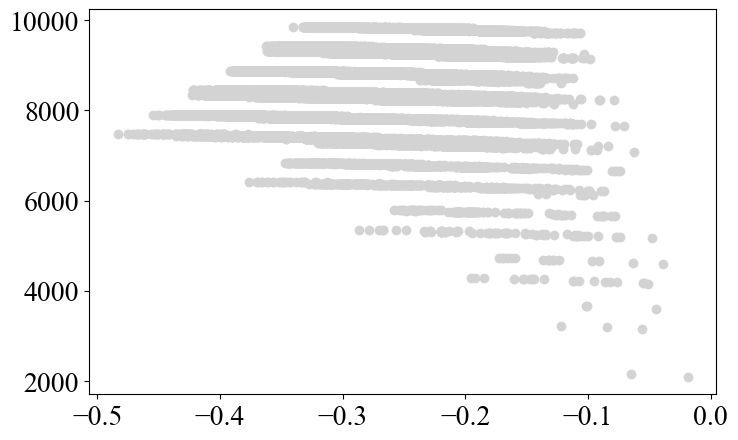

In [11]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
font = {'family' : "Times New Roman",
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
#plt.rcParams["font.family"] = "Times New Roman"

gold = (1+(5**0.5))/2
plt.figure(figsize=(5*gold,5))

plt.scatter(properties[:,1], properties[:,3], c = 'lightgrey', label = 'QM7-X')
index = [0,1,2,4]
mols = pd.read_csv('/work/projects/tcp/lmedrano/alessio/vae/mol-new/code/fhi/extract/xyzfiles2/12/data-12.dat', header = None).values[index]
print(mols)
for i in range(0, len(mols)):
    if i == 0:
        plt.scatter(float(mols[i][0].split()[2]), float(mols[i][0].split()[3]), c = 'turquoise', s = 50, label = r'samples $T_1$')
    else:
        plt.scatter(float(mols[i][0].split()[2]), float(mols[i][0].split()[3]), c = 'turquoise', s = 50)
        
plt.scatter(-1*p_stds[1] + p_means[1], 2*p_stds[3] + p_means[3], c = 'navy', marker = '*', s = 70, label = r'$T_1$')

mols = pd.read_csv('/work/projects/tcp/lmedrano/alessio/vae/mol-new/code/fhi/extract/xyzfiles/set2/data-set2.dat', header = None).values
print(mols)
for i in range(0, len(mols)):
    if i == 0:
        plt.scatter(float(mols[i][0].split()[2]), float(mols[i][0].split()[3]), c = 'orange', s = 50, label = r'samples $T_2$')
    else:
        plt.scatter(float(mols[i][0].split()[2]), float(mols[i][0].split()[3]), c = 'orange', s = 50)
                
plt.scatter(-1.5*p_stds[1] + p_means[1], 1*p_stds[3] + p_means[3], c = 'red', marker = '*', s = 70, label = r'$T_2$')
plt.legend(loc = 'lower right', prop = {'size': 14})
plt.xlim(-.5, -.2)
plt.ylim(80, 120)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.xlabel(r'$E_{MBD}$', fontdict={'size':22})
plt.ylabel(r'$\alpha$', fontdict={'size':22})
plt.tight_layout()
plt.savefig('./new_chem.pdf', dpi = 100)